# Collision Detection


In [18]:
import sys
!{sys.executable} -m pip install pipe

C:\Anaconda\envs\py35\python.exe


pyspark 2.2.0 requires py4j==0.10.4, which is not installed.
azure 2.0.0 has requirement azure-graphrbac~=0.30.0, but you'll have azure-graphrbac 0.31.0 which is incompatible.
keras-applications 1.0.4 has requirement keras>=2.1.6, but you'll have keras 2.0.8 which is incompatible.
keras-preprocessing 1.0.2 has requirement keras>=2.1.6, but you'll have keras 2.0.8 which is incompatible.
tensorflow-tensorboard 0.1.8 has requirement html5lib==0.9999999, but you'll have html5lib 0.999999999 which is incompatible.
bleach 1.5.0 has requirement html5lib!=0.9999,!=0.99999,<0.99999999,>=0.999, but you'll have html5lib 0.999999999 which is incompatible.
azure-mgmt 1.0.0 has requirement azure-mgmt-datalake-analytics~=0.1.4, but you'll have azure-mgmt-datalake-analytics 0.2.0 which is incompatible.
azure-mgmt 1.0.0 has requirement azure-mgmt-datalake-store~=0.1.4, but you'll have azure-mgmt-datalake-store 0.2.0 which is incompatible.
You are using pip version 10.0.1, however version 18.0 is availa

In [1]:
import numpy as np
import cv2
from utils.image import *
from utils.video import *
from utils.pipeutils import *
import os
from os.path import join,isfile,isdir
from os import listdir
from pipe import *
import random
import matplotlib.pyplot as plt
import math
import builtins

### Initial configuration

In [2]:
base_dir = 'd:\\datai'

`GetFiles` is the function that will return a generator containing files in given directory with given extension, and specified `label`

In [3]:
# return iterable { (label, path/video1), (label, path/video2), ... }
def GetFiles( path, label, ext ):
    global base_dir
    d = join(base_dir,path)
    p = listdir(d) | where( lambda p: p.endswith(ext) ) | as_list()
    return zip(np.repeat(label, len(p)), map( lambda p: join( base_dir, path, p ), p ) )

videos = GetFiles('train\\collisions', 1, ext='.mp4') \
            | chain_with( GetFiles('val\\not-collisions', 0, ext='.mp4') ) \
            | chain_with( GetFiles('train\\not-collisions', 0, ext='.mp4') ) \
            | chain_with( GetFiles('val\\collisions', 1, ext='.mp4') ) \
            | as_list

framerate = 25
video_size = 64
max_length = 5

# adorn the video to the tuple iterator, return cloned+appended tuple
def adornVideo(iterator, video_size=video_size, squarecrop=True):
    return iterator \
        | select( lambda f: f + ( 
            video_to_npy( f[1], 
                         #note weird thing here, width doesn't work they appear to be inverted
                         height=video_size, 
                         squarecrop=squarecrop, 
                         fps=framerate,
                         cropat=max_length
            ), ) )

### Define useful video functions

reading video from d:\datai\train\collisions\output001-24132.mp4
reading video from d:\datai\train\collisions\output001-24962.mp4
reading video from d:\datai\train\collisions\output002-4994.mp4
reading video from d:\datai\train\collisions\output003-24962.mp4
reading video from d:\datai\train\collisions\output004-31027.mp4


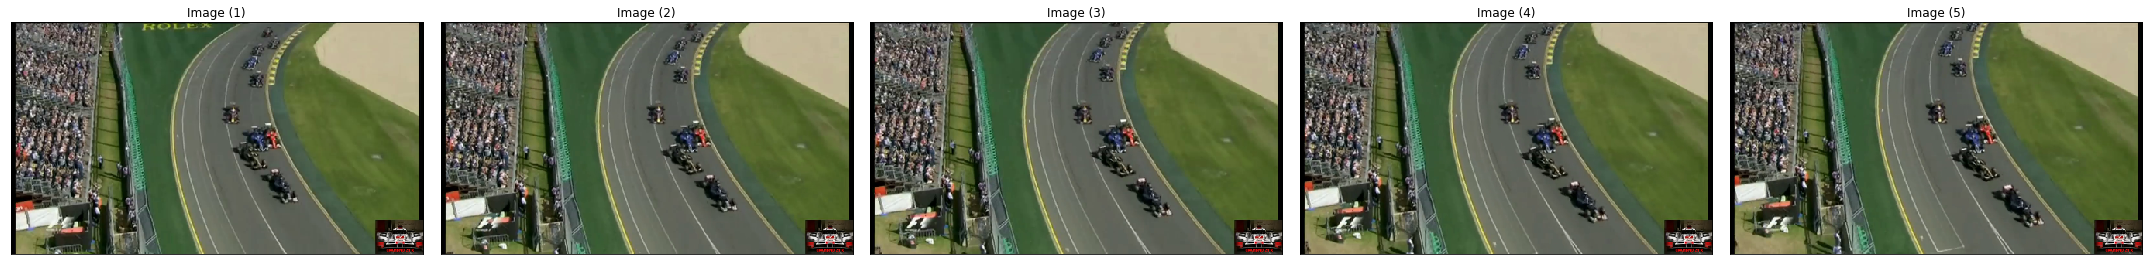

In [4]:
## Compute Dense Optical Flow
sample = adornVideo(videos,video_size=300,squarecrop=False) | skip(3) | take(1) | as_list
frames = sample[0][2][:,:,:,0:5]
show_images(frames[0:5])

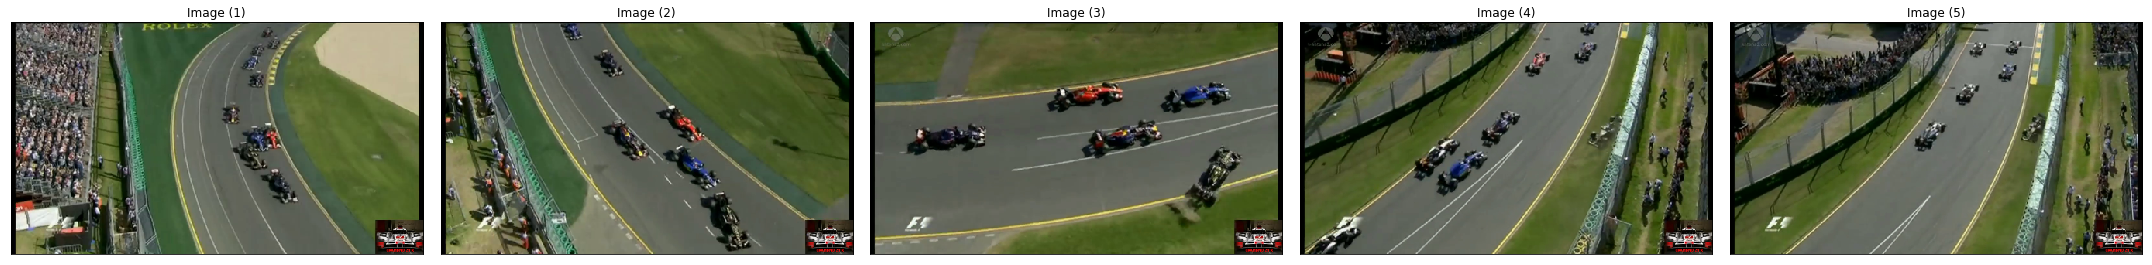

In [5]:
# get n sample frames from the video
def sample_idx(video,n=5):
    return range(0,len(video),len(video)//n)

def sample_frames(video,n=5):
    return video[sample_idx(video)]

fs = sample_frames(frames)
show_images(fs)

## Compute dense optical flow

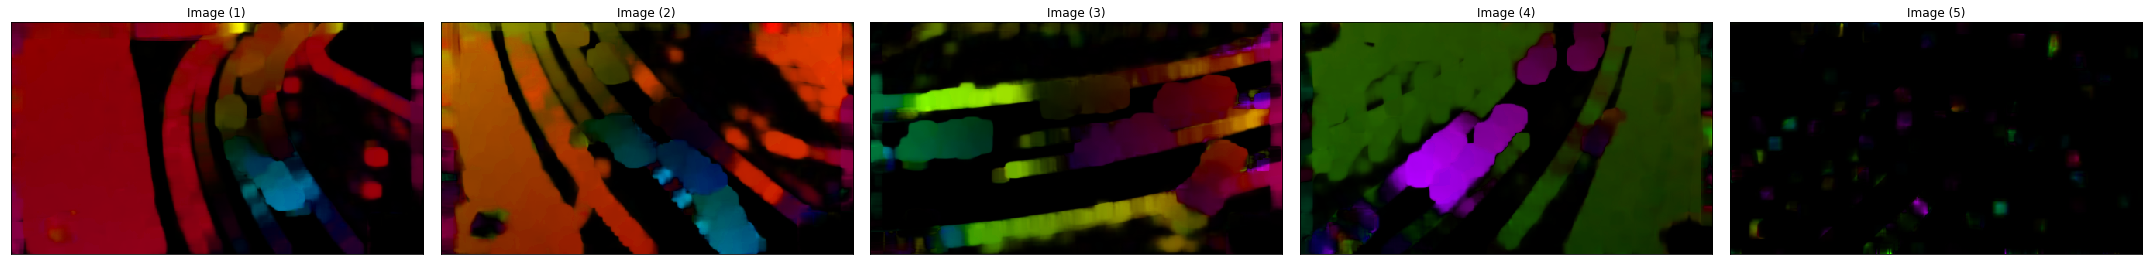

In [6]:
def dense_flow(frame1, frame2):
    f1 = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
    f2 = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    return cv2.calcOpticalFlowFarneback(f1, f2, None, 0.5, 3, 15, 3, 5, 1.2, 0)

def visualize_flow_hsv(frame1, flow):
    hsvImg = np.zeros_like(frame1)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsvImg[..., 0] = 0.5 * ang * 180 / np.pi
    hsvImg[..., 1] = 255
    hsvImg[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    return cv2.cvtColor(hsvImg, cv2.COLOR_HSV2BGR)

show_images([visualize_flow_hsv(frames[i],dense_flow(frames[i],frames[i+1])) for i in sample_idx(frames)])

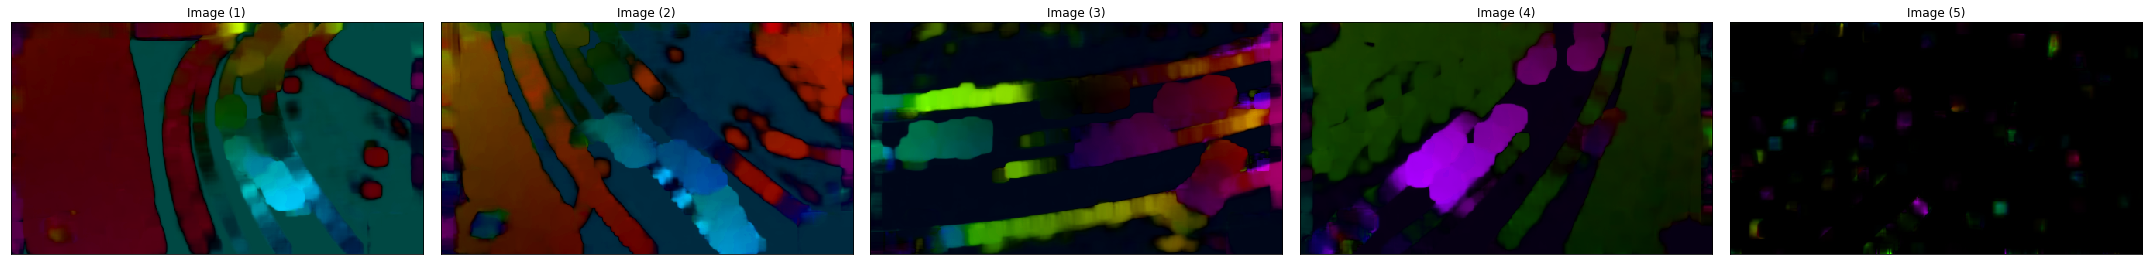

In [12]:
# Some naive stabilization
def dense_flow_stab(frame1, frame2):
    f = dense_flow(frame1, frame2)
    vec = np.average(f,axis=(0,1))
    mask = f==0
    f = f-vec
    f[mask]=0
    return f

show_images([visualize_flow_hsv(frames[i],dense_flow_stab(frames[i],frames[i+1])) for i in sample_idx(frames)])

Histograms of x and y displacements

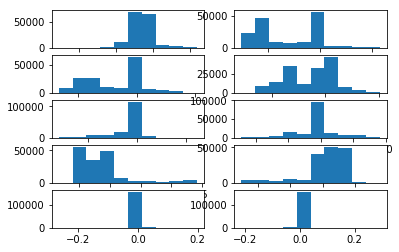

In [13]:
fs = [dense_flow(frames[i],frames[i+1]) for i in sample_idx(frames)]
fig, ax = plt.subplots(5,2)
for i,x in enumerate(fs):
    ax[i,0].hist(x[:,:,0].ravel())
    ax[i,1].hist(x[:,:,1].ravel())
plt.show()

Histogram of direction/magnitude

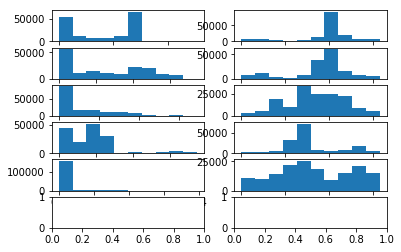

In [14]:
fs = [dense_flow(frames[i],frames[i+1]) for i in range(0,len(frames),len(frames)//5)]
fig, ax = plt.subplots(6,2)
for i,x in enumerate(fs):
    mag, ang = cv2.cartToPolar(x[..., 0], x[..., 1])
    ax[i,0].hist(mag[:,:].ravel())
    ax[i,1].hist(ang[:,:].ravel())
plt.show()

Computing histogram for the whole video

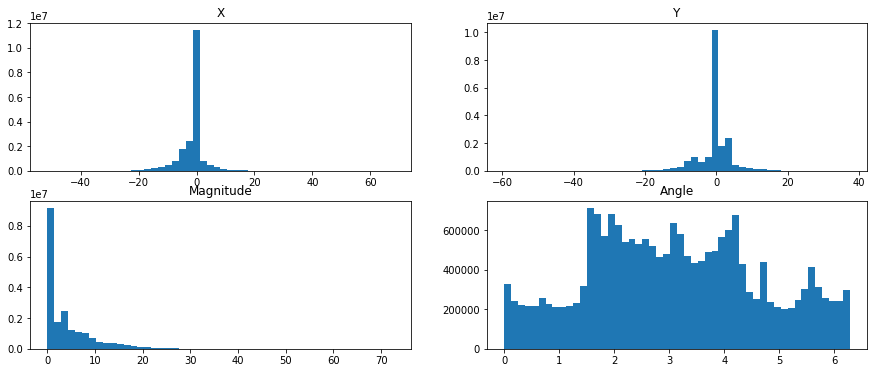

Max magnitude=72.59424591064453


In [15]:
flow = np.array([dense_flow(frames[i],frames[i+1]) for i in range(0,len(frames)-1)])
mag, ang = cv2.cartToPolar(flow[...,0],flow[...,1])
fig,ax=plt.subplots(2,2,figsize=(15,6))
ax[0,0].hist(flow[...,0].ravel(),bins=50); ax[0,0].set_title('X')
ax[0,1].hist(flow[...,1].ravel(),bins=50); ax[0,1].set_title('Y')
ax[1,0].hist(mag.ravel(),bins=50); ax[1,0].set_title('Magnitude')
ax[1,1].hist(ang.ravel(),bins=50); ax[1,1].set_title('Angle')
plt.show()
print("Max magnitude={}".format(mag.max()))

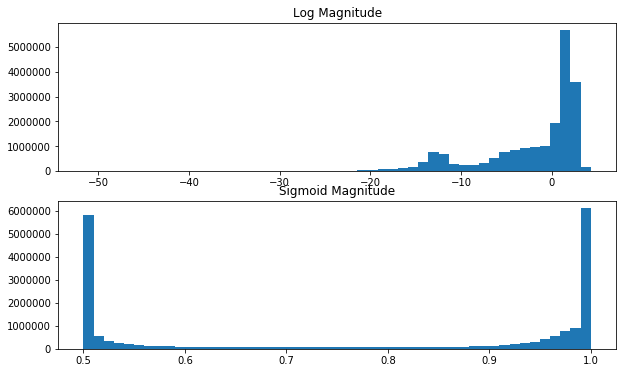

In [16]:
fig,ax=plt.subplots(2,1,figsize=(10,6))
ax[0].hist(np.log(mag.ravel()),bins=50); ax[0].set_title('Log Magnitude')
ax[1].hist(1/(1+np.exp(-mag.ravel())),bins=50); ax[1].set_title('Sigmoid Magnitude')
plt.show()

C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log


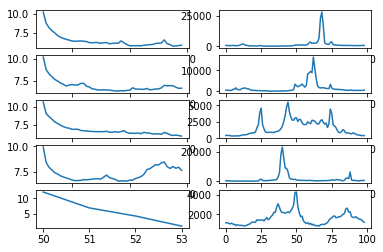

Max magnitude=34.50919723510742


In [17]:
fs = [dense_flow(frames[i],frames[i+1]) for i in range(0,len(frames),len(frames)//5)]
nbins=100
fig, ax = plt.subplots(5,2)
max_mag = 0
for i,x in enumerate(fs):
    mag, ang = cv2.cartToPolar(x[..., 0], x[..., 1])
    ax[i,0].plot(np.log(np.histogram(mag.ravel(),bins=np.arange(nbins)/nbins*10-5)[0])) # we consider log in range -5..5
    ax[i,1].plot(np.histogram(ang.ravel(),bins=np.arange(nbins)/nbins*2*math.pi)[0])
    max_mag=builtins.max(max_mag,mag.max())
plt.show()
print("Max magnitude={}".format(max_mag))

In [18]:
def get_flow_descriptor(video,nbins=100,mag_min=-7,max_max=7):
    def descr(f1,f2,bins,mbins):
        f = dense_flow_stab(f1,f2)
        mag, ang = cv2.cartToPolar(f[..., 0], f[..., 1])
        h1,bins1 = np.histogram(ang.ravel(),bins=bins)
        h2,bins2 = np.histogram(mag.ravel(),bins=mbins)
        return [[x,y] for x,y in zip(h1,np.log(1+h2))] # we take log of histograms to make range smaller
    abins = [i*2*math.pi/nbins for i in range(0,nbins+1)]
    mbins = np.arange(nbins+1)/nbins*(max_mag-mag_min)+mag_min
    return np.array([ descr(video[i],video[i+1],bins=abins,mbins=mbins) for i in range(0,len(video)-1)])

fd = get_flow_descriptor(frames)
print(frames.shape, fd.shape)

(125, 300, 533, 3) (124, 100, 2)


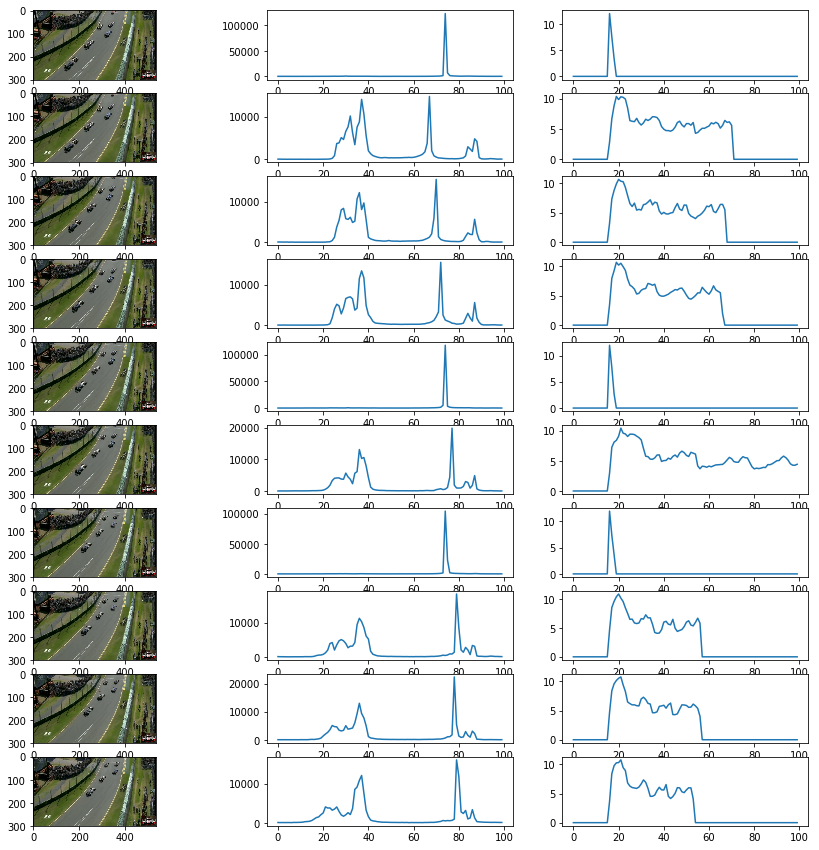

In [19]:
#fd = get_flow_descriptor(frames)
dx=90
fig, ax = plt.subplots(10,3,figsize=(15,15))
for i in range(0,10):
    ax[i,0].imshow(frames[i+dx])
    ax[i,1].plot(fd[i+dx,:,0])
    ax[i,2].plot(fd[i+dx,:,1])
plt.show()


## Store optical flow information on disk

In [22]:
to_process_flows = videos \
                | where( lambda f: not isfile( f[1].replace('.mp4','.flows.npy') ) )

flows_withvideo = adornVideo(to_process_flows, video_size=300, squarecrop=False)

# write out the vectorflows for each video
for v in flows_withvideo:
    hist = get_flow_descriptor(v[2])
    np.save(v[1].replace('.mp4','.flows.npy'),hist)

reading video from d:\datai\train\collisions\output001-24132.mp4
reading video from d:\datai\train\collisions\output001-24962.mp4
reading video from d:\datai\train\collisions\output002-4994.mp4
reading video from d:\datai\train\collisions\output003-24962.mp4
reading video from d:\datai\train\collisions\output004-31027.mp4
reading video from d:\datai\train\collisions\output004-4994.mp4
reading video from d:\datai\train\collisions\output005-4360.mp4
reading video from d:\datai\train\collisions\output006-24962.mp4
reading video from d:\datai\train\collisions\output006-4994.mp4
reading video from d:\datai\train\collisions\output007-24962.mp4
reading video from d:\datai\train\collisions\output007-31027.mp4
reading video from d:\datai\train\collisions\output007-4360.mp4
reading video from d:\datai\train\collisions\output008-24962.mp4
reading video from d:\datai\train\collisions\output012-4994.mp4
reading video from d:\datai\train\collisions\output013-31027.mp4
reading video from d:\datai\tra

reading video from d:\datai\train\not-collisions\output126-14767.mp4
reading video from d:\datai\train\not-collisions\output210-14767.mp4
reading video from d:\datai\train\not-collisions\output211-14767.mp4
reading video from d:\datai\train\not-collisions\output212-14767.mp4
reading video from d:\datai\train\not-collisions\output213-14767.mp4
reading video from d:\datai\train\not-collisions\output215-14767.mp4
reading video from d:\datai\train\not-collisions\output220-14767.mp4
reading video from d:\datai\train\not-collisions\output221-14767.mp4
reading video from d:\datai\train\not-collisions\output230-14767.mp4
reading video from d:\datai\train\not-collisions\output231-14767.mp4
reading video from d:\datai\train\not-collisions\output232-14767.mp4
reading video from d:\datai\train\not-collisions\output233-14767.mp4
reading video from d:\datai\train\not-collisions\output234-14767.mp4
reading video from d:\datai\train\not-collisions\output238-14767.mp4
reading video from d:\datai\train\

## Store videos on disk as np-arrays

In [46]:
# which ones do not have a numpy representation computed yet? i.e. no .npy file present
to_process = videos \
                | where( lambda f: not isfile( f[1].replace('.mp4','.videos.npy') ) )
to_process_withvideo = adornVideo( to_process )
videos_withvideo =  adornVideo( videos )

v = videos_withvideo | take(5) | select(lambda v: v[2].shape) |  as_list()

print(v)

# some assertions, apparently we are not getting the video size we require
for shape in v:
    assert( shape[2]==video_size and shape[1]==video_size )

reading video from d:\data\train\collisions\output000-26961.mp4
reading video from d:\data\train\collisions\output000.mp4
reading video from d:\data\train\collisions\output001.mp4
reading video from d:\data\train\collisions\output002-27378.mp4
reading video from d:\data\train\collisions\output002.mp4
reading video from d:\data\train\collisions\output003-27378.mp4
[(113, 64, 64, 3), (60, 64, 64, 3), (68, 64, 64, 3), (125, 64, 64, 3), (38, 64, 64, 3)]


In [47]:
# write these npy files out to the file system in the respective location
for v in to_process_withvideo:
    print( 'saved %s (class %d)' % ( v[1], v[0] ) )
    np.save(v[1].replace('.mp4','.videos.npy'), v[2])

reading video from d:\data\train\collisions\output000-26961.mp4
saved d:\data\train\collisions\output000-26961.mp4 (class 1)
reading video from d:\data\train\collisions\output000.mp4
saved d:\data\train\collisions\output000.mp4 (class 1)
reading video from d:\data\train\collisions\output001.mp4
saved d:\data\train\collisions\output001.mp4 (class 1)
reading video from d:\data\train\collisions\output002-27378.mp4
saved d:\data\train\collisions\output002-27378.mp4 (class 1)
reading video from d:\data\train\collisions\output002.mp4
saved d:\data\train\collisions\output002.mp4 (class 1)
reading video from d:\data\train\collisions\output003-27378.mp4
saved d:\data\train\collisions\output003-27378.mp4 (class 1)
reading video from d:\data\train\collisions\output003-5404.mp4
saved d:\data\train\collisions\output003-5404.mp4 (class 1)
reading video from d:\data\train\collisions\output003.mp4
saved d:\data\train\collisions\output003.mp4 (class 1)
reading video from d:\data\train\collisions\output

ok, so at this point we now have a numpy array for every single video file! the numpy arrays are fixed on some video size, length and frame rate i.e. 200^2, 5 seconds and 25fps.  

## Keras model on optical flow only

In [23]:
import keras

def npy_flow_from_directory( 
    colpath='collisions',
    noncolpath='not-collisions',
    ext='.npy'):
    # get a shuffled infinite sequence of training files
    files = GetFiles(join(base_dir,colpath), label=1, ext=ext) \
        | chain_with( GetFiles(join(base_dir,noncolpath), label=0, ext=ext) ) \
        | as_list() \
        | pshuffle() \
        | pcycle()

    # clever stuff here, the actual video will be loaded lazily
    files_withdata = files \
        | select( lambda f: f + ( np.load(f[1]) ,) )

    for x in files_withdata:
          yield x


C:\Anaconda\envs\py35\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [24]:
max_frames = videos | select(lambda x : x[1].replace('.mp4','.flows.npy')) \
           | select(lambda x : np.load(x)) \
           | select(lambda x : x.shape[0]) | max()
print(max_frames)

124


In [25]:
maxs = videos | select(lambda x : x[1].replace('.mp4','.flows.npy')) \
           | select(lambda x : np.load(x)) \
           | select(lambda x : x.max(axis=(0,1))) | as_npy
#print(maxs)
mins,maxs,avgs = maxs.min(axis=0),maxs.max(axis=0),np.average(maxs,axis=0)
print(mins,maxs,avgs)
ang_diap = (mins[0],avgs[0])
mag_diap = (mins[1],maxs[1])

[7112.           10.56015227] [1.47785000e+05 1.19822664e+01] [9.84658382e+04 1.17611636e+01]


In [26]:
def zero_pad(x):
    return np.pad(x,[(0,max_frames-x.shape[0]),(0,0),(0,0)],'constant',constant_values=[(0,0),(0,0),(0,0)])

@Pipe
def zero_pad_flow(flow):
    for x in flow:
        yield x[0],x[1],zero_pad(x[2])
        
@Pipe
def extend_channel(flow):
    for x in flow:
        yield x[0],x[1],x[2].reshape(x[2].shape[0],x[2].shape[1],1)
        
@Pipe
def normalize(flow):
    for x in flow:
        x2 = x[2]
        x2[:,:,0] = (x2[:,:,0]-ang_diap[0]) / (ang_diap[1]-ang_diap[0])
        x2[:,:,1] = (x2[:,:,1]-mag_diap[0]) / (mag_diap[0]-mag_diap[1])
        yield x[0],x[1],x2

In [27]:
train_flow = npy_flow_from_directory(colpath='train/collisions',noncolpath='train/not-collisions',ext='.flows.npy') \
            | zero_pad_flow | normalize()
val_flow = npy_flow_from_directory(colpath='val/collisions',noncolpath='val/not-collisions',ext='.flows.npy') \
            | zero_pad_flow | normalize()

In [28]:
train_flow | take(1) | select (lambda x: x[2].shape) | as_list

[(124, 100, 2)]

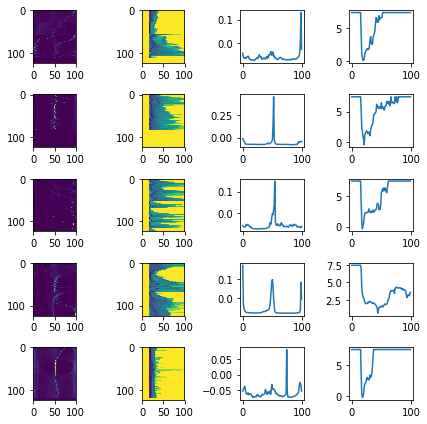

In [29]:
ims = train_flow | take(5) | select (lambda x: x[2])
fig, ax = plt.subplots(5,4,figsize=(6,6))
for i,x in enumerate(ims):
    ax[i,0].imshow(x[:,:,0])
    ax[i,1].imshow(x[:,:,1])
    ax[i,2].plot(x[0,:,0])
    ax[i,3].plot(x[0,:,1])
plt.tight_layout()
plt.show()
    

In [30]:
batchsize = 20
bins = 100

@Pipe
def to_batches(flow, batchsize=batchsize):
    while(True):
        batch = np.zeros( (batchsize, max_frames, bins, 2 ) )
        labels = np.zeros( (batchsize,1))
        for i in range(batchsize):
            data = next(flow)
            batch[i] = data[2]
            labels[i] = data[0]
        yield ( batch, labels )

In [41]:
from keras import layers
from keras import models
from keras import optimizers
from keras.regularizers import l2

model = models.Sequential()
model.add(layers.AveragePooling2D((2, 2),input_shape=(max_frames, bins, 2)))
model.add(layers.Conv2D(8, (3, 3), data_format='channels_last',activation='relu',kernel_initializer='glorot_uniform',kernel_regularizer=l2(0.01)))
model.add(layers.AveragePooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3) ,activation='relu',kernel_initializer='glorot_uniform',kernel_regularizer=l2(0.01)))
model.add(layers.AveragePooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100,activation='relu',kernel_initializer='glorot_uniform',kernel_regularizer=l2(0.01)))
model.add(layers.Dense(1, activation='sigmoid',kernel_initializer='glorot_uniform',kernel_regularizer=l2(0.01)))
model.compile(loss='binary_crossentropy',
              #optimizer=optimizers.Nadam(lr=0.005),
              optimizer=optimizers.adam(),
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d_11 (Averag (None, 62, 50, 2)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 48, 8)         152       
_________________________________________________________________
average_pooling2d_12 (Averag (None, 30, 24, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 22, 16)        1168      
_________________________________________________________________
average_pooling2d_13 (Averag (None, 14, 11, 16)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2464)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2464)              0         
__________

In [42]:
hist = model.fit_generator(
      train_flow | to_batches,
      steps_per_epoch=100, 
      validation_data=val_flow | to_batches,
      use_multiprocessing=False, # has to be false on windows..
      validation_steps = 10,
      epochs=20)

Epoch 1/20
100/100 [==============================] - 3s 26ms/step - loss: 1.2022 - acc: 0.7650 - val_loss: 0.5867 - val_acc: 0.9500
Epoch 2/20
100/100 [==============================] - 2s 21ms/step - loss: 0.4191 - acc: 0.9565 - val_loss: 0.4675 - val_acc: 0.8950
Epoch 3/20
100/100 [==============================] - 2s 21ms/step - loss: 0.2990 - acc: 0.9790 - val_loss: 0.4001 - val_acc: 0.9500
Epoch 4/20
100/100 [==============================] - 2s 22ms/step - loss: 0.2722 - acc: 0.9775 - val_loss: 0.3713 - val_acc: 0.9750
Epoch 5/20
100/100 [==============================] - 2s 22ms/step - loss: 0.2288 - acc: 0.9910 - val_loss: 0.3332 - val_acc: 0.8900
Epoch 6/20
100/100 [==============================] - 2s 22ms/step - loss: 0.2427 - acc: 0.9775 - val_loss: 0.4183 - val_acc: 0.8750
Epoch 7/20
100/100 [==============================] - 2s 22ms/step - loss: 0.2141 - acc: 0.9940 - val_loss: 0.2983 - val_acc: 0.9750
Epoch 8/20
100/100 [==============================] - 2s 22ms/step - 

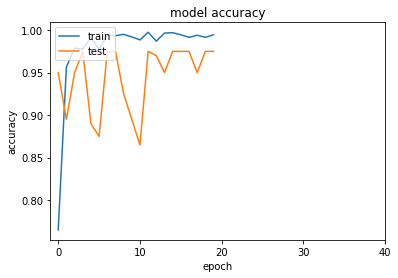

In [43]:
def plotHistory(history):
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xticks(range(0,50,10))
        #plt.yticks(range(0,1,0.1))
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
plotHistory(hist)

## Video Augmentation

For every single video file, we compute a random augmentation consistently across all of the frames

In [5]:
import keras
from keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     horizontal_flip=True)

image_datagen = ImageDataGenerator(**data_gen_args)

def videoFlowWithAugmentation( 
    colpath='collisions',
    noncolpath='not-collisions',
    augment=True, 
    diff=False,
    normalize=True):
    # get a shuffled infinite sequence of training videos
    videos = GetVideos(join(base_dir,colpath), label=1, ext='.npy') \
        | chain_with( GetVideos(join(base_dir,noncolpath), label=0, ext='.npy') ) \
        | as_list() \
        | pshuffle() \
        | pcycle()

    # clever stuff here, the actual video will be loaded lazily
    videos_withdata = videos \
        | select( lambda f: f + ( np.load(f[1]) ,) )

    for video in videos_withdata:
        # for every frame in this video generate the same transformation
        # and yield it all back in sequence order
        trans = image_datagen.get_random_transform(video[2].shape)
        augmentedVideo = np.zeros( video[2].shape )
        for i in range(video[2].shape[0]):
            if augment:
                augmentedVideo[i] = image_datagen.apply_transform(video[2][i], trans)
            else:
                augmentedVideo[i] = video[2][i]
            
            # now is a good time to transform the video onto 0-1
            # we need to do this to get convergence when we train i.e. homogenise features
            if normalize:
                augmentedVideo[i] = augmentedVideo[i] / 255
            
            # take xth order differences of frames to convey pixel-wise temporal changes
            if diff is not None:
                augmentedVideo[i, 0:augmentedVideo[i].shape[0]-diff] = np.diff(augmentedVideo[i], axis=0, n=diff)
            
        yield video[:-1] + (augmentedVideo,)
            
train_flow = videoFlowWithAugmentation(colpath='train/collisions',noncolpath='train/not-collisions', diff=None)
# remember, on validation we don't want to augment anything!
val_flow = videoFlowWithAugmentation(colpath='val/collisions',noncolpath='val/not-collisions', augment=False)

C:\Anaconda\envs\py35\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
import keras
print(keras.__version__)

2.2.2


let's visualize the augmented results for this video

In [7]:
def getTestImages(flow, howmany=5):
    augmentedVideo = next(flow)
    print(augmentedVideo[2].shape)
    return range(augmentedVideo[2].shape[0]) \
        | select( lambda i: augmentedVideo[2][i] ) \
        | take(howmany)

# show some augmented train images
images = getTestImages(train_flow)
for x in range(2):
    images = images | chain_with( getTestImages(train_flow) )

show_images( images | as_list, cols=4 )

# and do the same for some validation images
images = getTestImages(val_flow)
for x in range(2):
    images = images | chain_with( getTestImages(val_flow) )

show_images( images | as_list, cols=4 )

IndexError: tuple index out of range

ok this is looking pretty good, next thing is to zeropad so that the number of frames is always the same i.e. max seconds * framerate

In [38]:
def zeroPadVideos(videoStream):
    for video in videoStream:
        zeroPadded = np.zeros( ( max_length * framerate, video_size, video_size, 3 ) )
        zeroPadded[ 0:video[2].shape[0], :, : ,: ] = video[2]
        yield video[:-1] + (zeroPadded,)

In [39]:
def getVectorFlowHistogramsForStream( videoStream ):
    for video in videoStream:
        
        histogram = np.zeros( 20 )
        
        for frame in range(video)
        
        # do code to compute the 
        
        yield histogram

SyntaxError: unexpected EOF while parsing (<ipython-input-39-6e8e1a0c91dd>, line 1)

let's check that the framerate is indeed fixed

In [929]:
for x in range(3):
    assert( next( zeroPadVideos( train_flow ) )[2].shape[0]==max_length * framerate )

OK the next problem is we have a nice generator for videos, but we are doing a 4d CNN with videos and need a batch dimension, so let's write another generator which will batch X videos at a time

```
next( zeroPadVideos( flow ) )[3].shape
```
== (125, 200, 200, 3)


In [930]:
def getBatchVideosFlow(flow, batchsize):
    while(True):
        batch = np.zeros( (batchsize, max_length * framerate, video_size, video_size, 3 ) )
        labels = np.zeros( (batchsize,1))
        for i in range(batchsize):
            video = next( zeroPadVideos( flow ) )
            batch[i] = video[2]
            labels[i] = video[0]
        yield ( batch, labels )

We now have a generator giving us batches of training examples and respective labels, we can feed this into keras fit_generator!

In [931]:
from sys import getsizeof

r = next( getBatchVideosFlow( train_flow, 20 ) )
print(r[0].shape)
print(r[1].shape)

getsizeof(r[0])/1024**3
# == 2.4gb for 20 videos of 125 frames @ 200^2*3

(20, 125, 64, 64, 3)
(20, 1)


0.22888198494911194

now let's try and train keras on it

In [634]:
from keras import layers
from keras import models
from keras import regularizers

prelu = layers.advanced_activations.LeakyReLU(alpha=0.3)

model = models.Sequential()
model.add(layers.Conv3D(15, (1, 3, 3),
                        input_shape=(max_length * framerate, video_size, video_size, 3)))
model.add(prelu)
model.add(layers.AveragePooling3D((4, 2, 2)))
model.add(layers.Conv3D(32, (2, 3, 3) ))
model.add(prelu)
model.add(layers.AveragePooling3D((5, 2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20))
model.add(prelu)
model.add(layers.Dense(20))
model.add(prelu)
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_146 (Conv3D)          (None, 50, 46, 46, 15)    420       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   multiple                  0         
_________________________________________________________________
average_pooling3d_8 (Average (None, 12, 23, 23, 15)    0         
_________________________________________________________________
conv3d_147 (Conv3D)          (None, 11, 21, 21, 32)    8672      
_________________________________________________________________
average_pooling3d_9 (Average (None, 2, 10, 10, 32)     0         
_________________________________________________________________
flatten_67 (Flatten)         (None, 6400)              0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 6400)              0         
__________

In [635]:
from keras import optimizers

diff_val = None

train_flow = videoFlowWithAugmentation(colpath='./train/collisions',noncolpath='./train/not-collisions', augment=True, diff=diff_val)
# remember, on validation we don't want to augment anything!
val_flow = videoFlowWithAugmentation(colpath='./val/collisions',noncolpath='./val/not-collisions', augment=False, diff=diff_val)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Nadam(lr=0.005),
              metrics=['acc'])

print('training with videosize: %s framerate: %d' % (video_size, framerate))

history = model.fit_generator(
      getBatchVideosFlow( train_flow, 20 ),
      steps_per_epoch=9, 
      validation_data=getBatchVideosFlow( val_flow, 10 ), 
      # has to be false on windows..
      use_multiprocessing=False, 
      validation_steps = 8,
      epochs=30)

training with videosize: 48 framerate: 10
Epoch 1/30
9/9 [==============================] - 5s 582ms/step - loss: 1.0420 - acc: 0.6056 - val_loss: 0.6862 - val_acc: 0.6500
Epoch 2/30
9/9 [==============================] - 4s 463ms/step - loss: 0.6548 - acc: 0.6444 - val_loss: 0.6772 - val_acc: 0.6375
Epoch 3/30
9/9 [==============================] - 5s 504ms/step - loss: 0.7260 - acc: 0.6056 - val_loss: 0.6650 - val_acc: 0.7250
Epoch 4/30
9/9 [==============================] - 5s 514ms/step - loss: 0.6504 - acc: 0.6500 - val_loss: 0.7478 - val_acc: 0.4875
Epoch 5/30
9/9 [==============================] - 5s 506ms/step - loss: 0.6437 - acc: 0.6167 - val_loss: 0.6660 - val_acc: 0.6750
Epoch 6/30
9/9 [==============================] - 4s 500ms/step - loss: 0.6253 - acc: 0.6389 - val_loss: 0.7026 - val_acc: 0.5125
Epoch 7/30
9/9 [==============================] - 5s 511ms/step - loss: 0.6178 - acc: 0.6222 - val_loss: 0.7003 - val_acc: 0.4875
Epoch 8/30
9/9 [==============================] 

Now we plot to see the convergence behaviour and overfitting

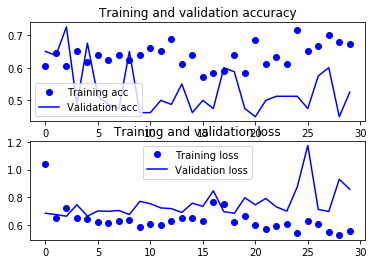

In [636]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


f, (ax1,ax2) = plt.subplots(2,1)

epochs = range(len(acc))

ax1.plot(epochs, acc, 'bo', label='Training acc')
ax1.plot(epochs, val_acc, 'b', label='Validation acc')
ax1.set_title('Training and validation accuracy')
ax1.legend()


ax2.plot(epochs, loss, 'bo', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend()

plt.show()


lets try using conv base as an input now

In [932]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(video_size, video_size, 3))

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

add the conv base into a basic classifier 

Lets write a new generator which will give us embeddings of the frames in 2 dimensions 

In [933]:
from keras import optimizers
from functools import reduce

def getBatchVideoEmbeddingsFlow(flow, batchsize, color_channel=None):
    while(True):
        oshape = (batchsize, max_length * framerate, reduce(mul, conv_base.output_shape[1:]) )
        if color_channel is True: oshape = oshape + (1,)
            
        batch = np.zeros( oshape )
        labels = np.zeros( (batchsize,1))
        for i in range(batchsize):
            video = next(zeroPadVideos( flow ))
            embedding = conv_base.predict( video[2] )
            embedding = embedding.reshape(oshape[1:])
            batch[i] = embedding
            labels[i] = video[0]
        yield ( batch, labels )

We can visualise the results

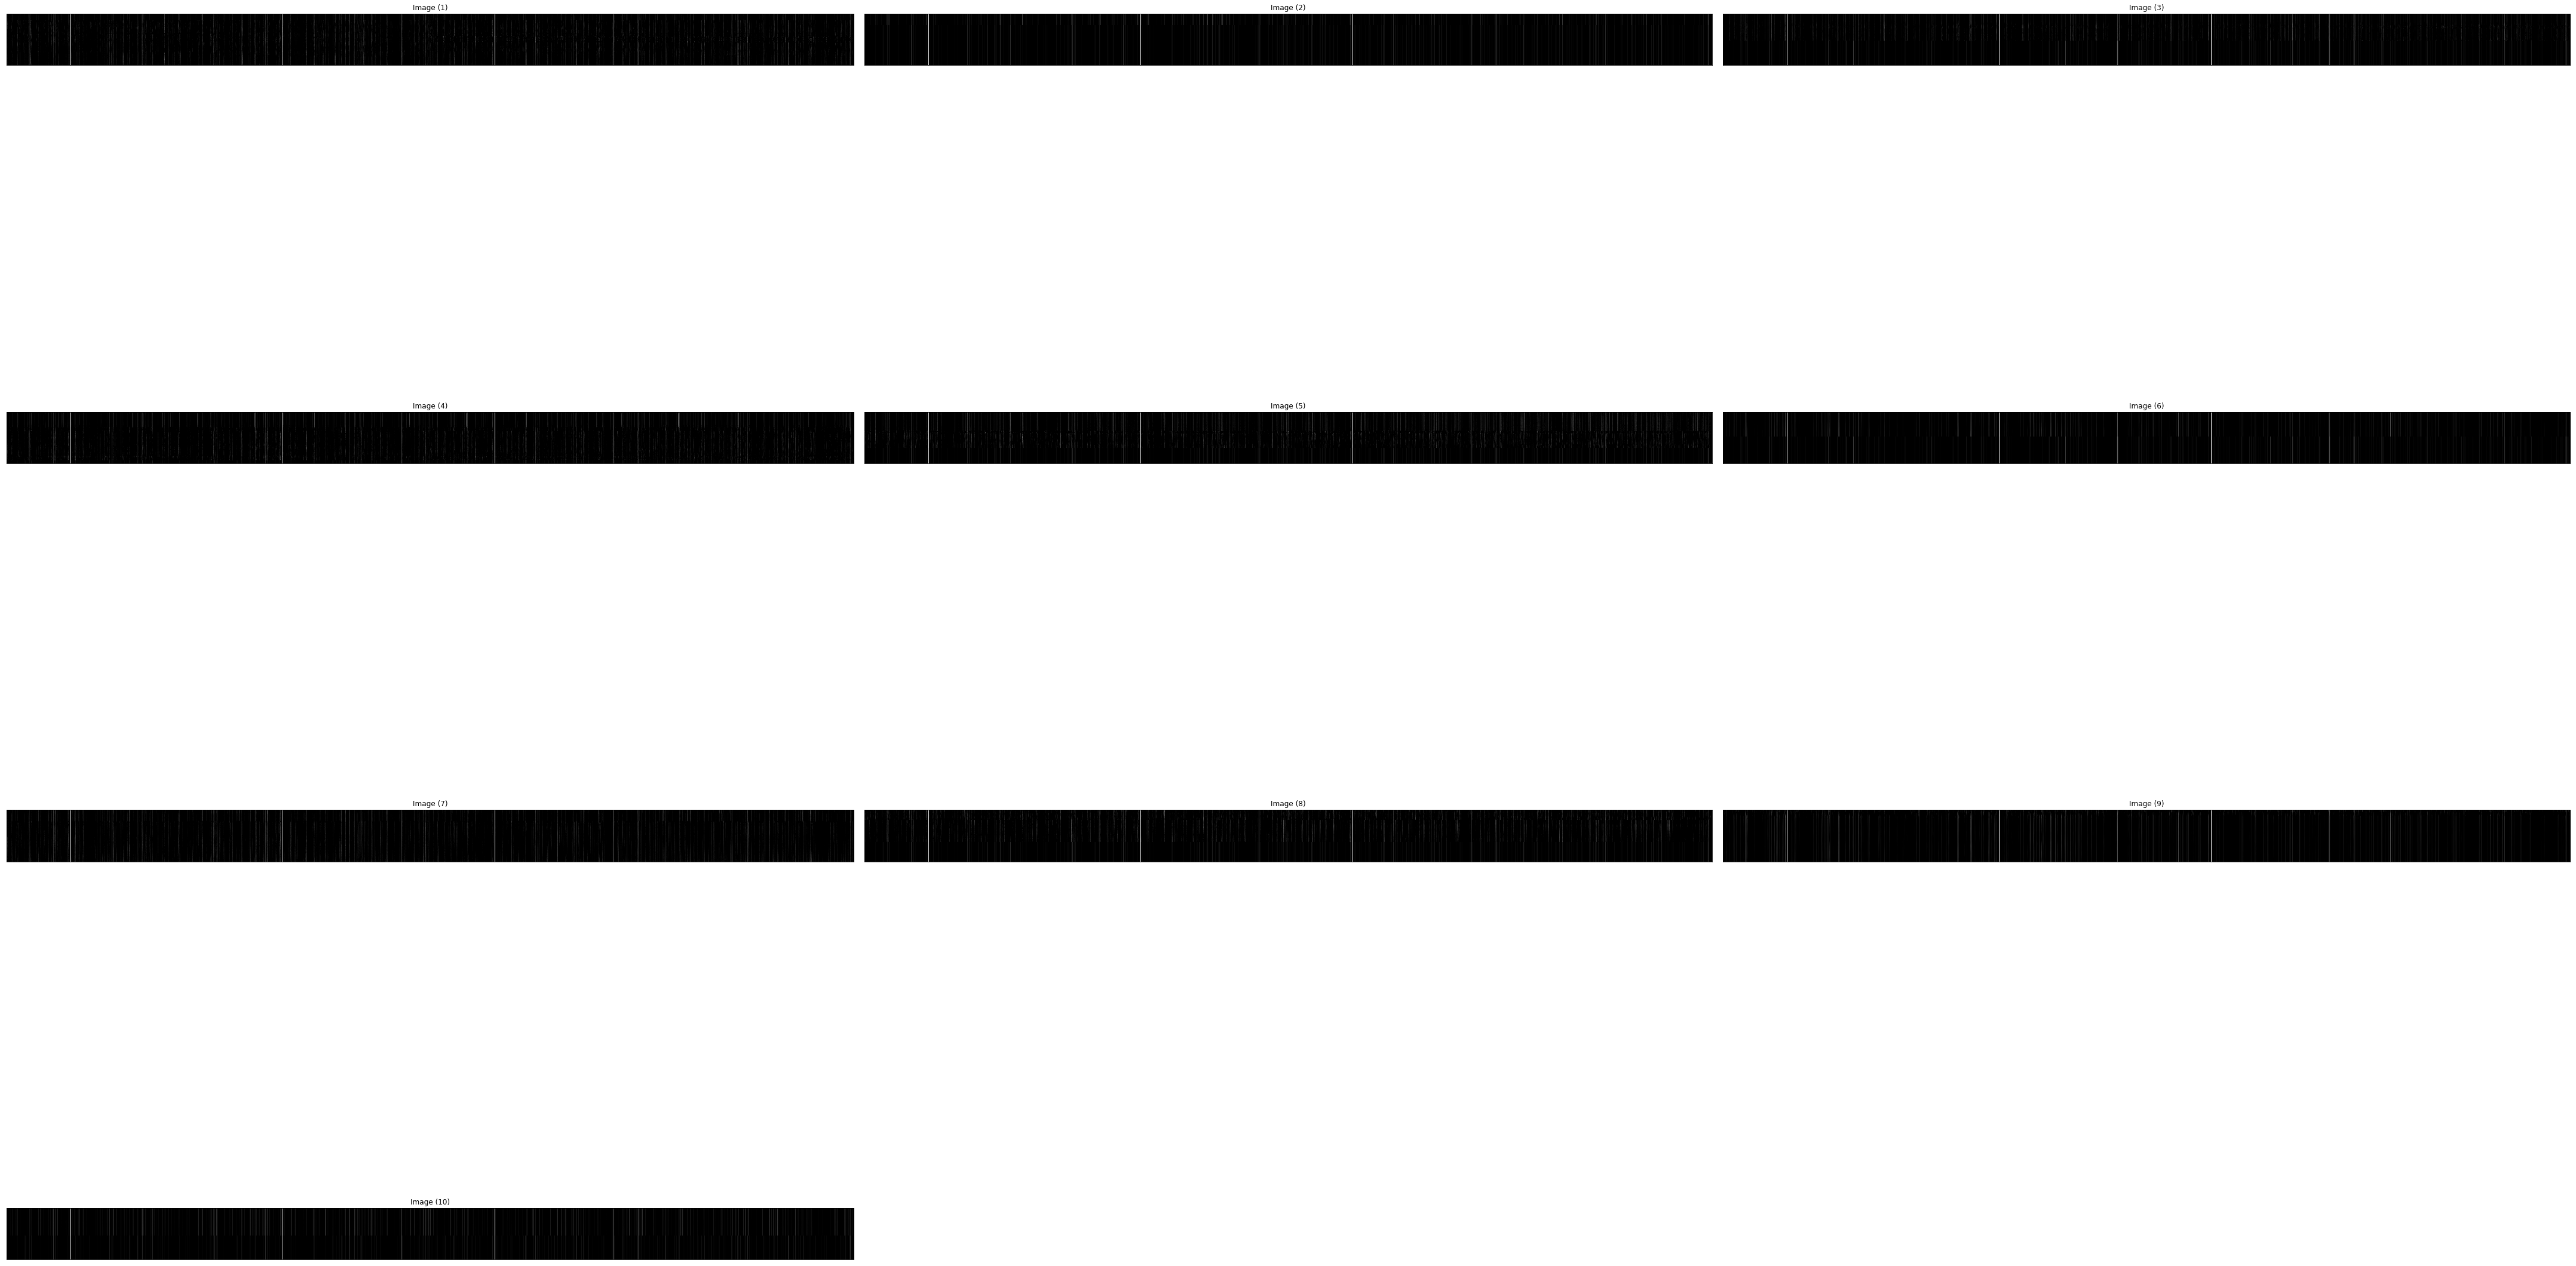

In [934]:
train_flow = videoFlowWithAugmentation(colpath='./train/collisions',noncolpath='./train/not-collisions', augment=False, diff=False)
batch = next(getBatchVideoEmbeddingsFlow(train_flow,20))


show_images( range(10) | select( lambda i: batch[0][i] ) | as_list, cols=4 )

now let's build a simple 2d cnn to take these as inputs

In [953]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(30, (3,1), activation='relu',
                        input_shape=(max_length * framerate, reduce(mul, conv_base.output_shape[1:]), 1)))
model.add(layers.AveragePooling2D((2,2)))
model.add(layers.Conv2D(64, (3,2), activation='relu'))
model.add(layers.AveragePooling2D((2,10)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_107 (Conv2D)          (None, 123, 2048, 30)     120       
_________________________________________________________________
average_pooling2d_11 (Averag (None, 61, 1024, 30)      0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 59, 1023, 64)      11584     
_________________________________________________________________
average_pooling2d_12 (Averag (None, 29, 102, 64)       0         
_________________________________________________________________
flatten_142 (Flatten)        (None, 189312)            0         
_________________________________________________________________
dropout_128 (Dropout)        (None, 189312)            0         
_________________________________________________________________
dense_464 (Dense)            (None, 10)                1893130   
__________

In [951]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Nadam(lr=0.005),
              metrics=['acc'])

print('training with videosize: %s framerate: %d' % (video_size, framerate))

train_flow = videoFlowWithAugmentation(colpath='./train/collisions',noncolpath='./train/not-collisions', augment=True, diff=diff_val)
# remember, on validation we don't want to augment anything!
val_flow = videoFlowWithAugmentation(colpath='./val/collisions',noncolpath='./val/not-collisions', augment=False, diff=diff_val)

history = model.fit_generator(
      getBatchVideoEmbeddingsFlow(train_flow,10, color_channel=True),
      steps_per_epoch=18, 
      validation_data=getBatchVideoEmbeddingsFlow( val_flow, 10, color_channel=True ), 
      # has to be false on windows..
      use_multiprocessing=False, 
      validation_steps = 8,
      epochs=100)

training with videosize: 64 framerate: 25
Epoch 1/100
18/18 [==============================] - 44s 2s/step - loss: 5.7608 - acc: 0.6000 - val_loss: 8.4620 - val_acc: 0.4750
Epoch 2/100
18/18 [==============================] - 31s 2s/step - loss: 5.9100 - acc: 0.6333 - val_loss: 8.6635 - val_acc: 0.4625
Epoch 3/100
18/18 [==============================] - 31s 2s/step - loss: 6.4571 - acc: 0.5833 - val_loss: 6.1819 - val_acc: 0.5125
Epoch 4/100
18/18 [==============================] - 30s 2s/step - loss: 1.4982 - acc: 0.5667 - val_loss: 0.7055 - val_acc: 0.4750
Epoch 5/100
18/18 [==============================] - 31s 2s/step - loss: 0.6723 - acc: 0.6111 - val_loss: 0.7138 - val_acc: 0.5000
Epoch 6/100
18/18 [==============================] - 30s 2s/step - loss: 0.6776 - acc: 0.6167 - val_loss: 0.7127 - val_acc: 0.5000
Epoch 7/100
18/18 [==============================] - 30s 2s/step - loss: 0.6724 - acc: 0.6167 - val_loss: 0.7196 - val_acc: 0.4875
Epoch 8/100
18/18 [======================

Epoch 63/100
18/18 [==============================] - 31s 2s/step - loss: 0.6616 - acc: 0.6278 - val_loss: 0.7194 - val_acc: 0.5000
Epoch 64/100
18/18 [==============================] - 31s 2s/step - loss: 0.6672 - acc: 0.6111 - val_loss: 0.7200 - val_acc: 0.5000
Epoch 65/100
18/18 [==============================] - 31s 2s/step - loss: 0.6663 - acc: 0.6167 - val_loss: 0.7259 - val_acc: 0.4875
Epoch 66/100
18/18 [==============================] - 31s 2s/step - loss: 0.6662 - acc: 0.6167 - val_loss: 0.7262 - val_acc: 0.4875
Epoch 67/100
18/18 [==============================] - 31s 2s/step - loss: 0.6614 - acc: 0.6278 - val_loss: 0.7275 - val_acc: 0.4875
Epoch 68/100
18/18 [==============================] - 32s 2s/step - loss: 0.6663 - acc: 0.6167 - val_loss: 0.7339 - val_acc: 0.4750
Epoch 69/100
18/18 [==============================] - 31s 2s/step - loss: 0.6769 - acc: 0.5944 - val_loss: 0.7246 - val_acc: 0.4875
Epoch 70/100
18/18 [==============================] - 31s 2s/step - loss: 0.

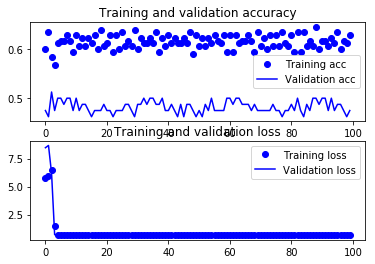

In [952]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


f, (ax1,ax2) = plt.subplots(2,1)

epochs = range(len(acc))

ax1.plot(epochs, acc, 'bo', label='Training acc')
ax1.plot(epochs, val_acc, 'b', label='Validation acc')
ax1.set_title('Training and validation accuracy')
ax1.legend()


ax2.plot(epochs, loss, 'bo', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend()

plt.show()
